# Шаг 5: Improvement_1. Modeling

In [1]:
folder = '2. improvement_1'

## Импорт библиотек

In [184]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option("display.max_columns", 50)
pd.options.display.max_rows = 20

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")  
sns.set_context("talk", font_scale=0.6)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"})

from tqdm import tqdm
from tqdm import tqdm_notebook


import association_metrics as am

In [185]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [186]:
# Базовые модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Выбор параметров
from sklearn.model_selection import cross_val_score, StratifiedKFold

import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

from sklearn.metrics import roc_auc_score
from mlxtend.evaluate import bias_variance_decomp

In [187]:
from sklearn.base import BaseEstimator, TransformerMixin

In [188]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.decomposition import PCA

In [189]:
RANDOM_STATE = 42

## Загрузка данных

In [190]:
initial_X_y = pd.read_pickle('../data/initial_X_y.pkl')
X = initial_X_y['X'].copy()
y = initial_X_y['y'].copy()

In [191]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,No,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,No,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,No,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,No,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [192]:
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

## Разделение на тестовую и обучающую выборки

Выделим категориальные и числовые признаки

In [193]:
numeric_cols = list(X.select_dtypes(include=[np.number]).columns)
display(X[numeric_cols].head(3))

,tenure,MonthlyCharges,TotalCharges
0,1.0,29.85,29.85
1,34.0,56.95,1889.50
2,2.0,53.85,108.15


In [194]:
categoric_cols = list(X.select_dtypes(exclude=[np.number]).columns)
display(X[categoric_cols].head(3))

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check


Разделим исходный датасет на обучающую и тестовую выборки

In [195]:
X, y = shuffle(X, y, random_state=RANDOM_STATE)

In [196]:
y = y.map({'Yes':1, 'No':0})

display(y.value_counts())

0    5174
1    1869
Name: Churn, dtype: int64

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки:  {X_test.shape}")

Размер обучающей выборки: (4930, 19)
Размер тестовой выборки:  (2113, 19)


## Pipeline configurations

#### Сформируем новый Pipeline для линейной модели класса Логистическая регрессия

Введем следующие модификации в наш Pipeline для модели LogisticRegression:
- 'Feature_transf' - шаг, на котором происходит преобразование признака `TotalCharges`
- 'PCA' - введение шаг уменьшения размерности методом PCA.

In [198]:
class Feature_transf(BaseEstimator, TransformerMixin):
    """
    Класс преобразования признаков

    """

    def __init__(self, copy=True):

        self.copy = copy    
     
    def __TotalCharges_log(self, df: pd.Series) -> pd.DataFrame:
    
        '''
            Функция дополнительной трансформации признаков:
                1) Преобразование признака TotalCharges на log шкалу;
        '''

        p = 0.25537409875188244
        df_local = df.copy()

        # Обработка TotalCharges
        df_local = np.where(df_local.apply(lambda x: True if (x==0 or x==np.nan) else False), 0, 
                            df_local.apply(lambda x: ((x**p) - 1)/p))

        return df_local
    

    def fit(self, X, y=None):
        # ничего не делаем )) 
        return self

    def transform(self, X):

        if self.copy:
            X = X.copy()  
           
        X['TotalCharges']= self.__TotalCharges_log(X['TotalCharges'])
        
        # transform возвращает X
        return X

In [199]:
def get_LogReg_pipe():
    
    '''
    Pipeline модели LogisticRegression
    '''
    
    categoric_cols = ['gender',
     'SeniorCitizen',
     'Partner',
     'Dependents',
     'PhoneService',
     'MultipleLines',
     'InternetService',
     'OnlineSecurity',
     'OnlineBackup',
     'DeviceProtection',
     'TechSupport',
     'StreamingTV',
     'StreamingMovies',
     'Contract',
     'PaperlessBilling',
     'PaymentMethod']

    numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']


    # Трансформер числовых признаков
    numeric_pipe = Pipeline([
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler())])

    # Трансформер категориальных признаков
    categoric_pipe = Pipeline([
            ('OHE', OneHotEncoder(sparse=False))])

    transformers = [("numeric", numeric_pipe, numeric_cols), 
                    ("categoric", categoric_pipe, categoric_cols)]

    Preprocessor = Pipeline([
                    ('Feature_transf', Feature_transf()),
                    ('ColumnTransformer', ColumnTransformer(transformers=transformers)),
                    ('PCA', PCA(n_components=21)),])

    log_reg_pipe = Pipeline([
            
            ('Preprocessor', Preprocessor),
            ('Model', LogisticRegression())])
    
    return log_reg_pipe

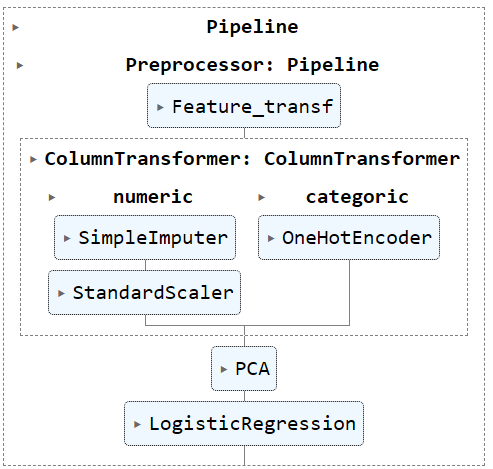

## Поиск наилучших праметров модели

На данном шаге будем осуществлять поиск наилучших параметров модели, при этом:
- Поиск будет осуществляться с помощью библиотеки Optuna;
- Поиск будет осуществляться только на обучающей (train) выборке. Финальное качество будем проверять на тестовой выборке, которая в подборе параметров и при обучении не участвовала.

In [226]:
# Создаем словари, в которые будем записывать результаты поиска оптимальных мараметров

optuna_model_results = dict()   # словарь наилучших параметров
model_scores = dict()           # словарь оценок качества на обучающей и тестовой выборках

Подготовим функцию для проведения оценки качества на тестовой выборке

In [248]:
def test_Model(description: str, model, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):
    
    
    print('\n')
    print(f'***{description}***')
    
 
    print('Step 1: Обучение')
    results = pd.DataFrame()
    
    model.fit(X_train, y_train)
    
    print('Step 2: Предсказание на train')
    pred = model.predict_proba(X_train)[:,1]
    
    train_score = roc_auc_score(y_train, pred)
    
    print('Step 3: Предсказание на test')
    pred = model.predict_proba(X_test)[:,1]
    
    test_score = roc_auc_score(y_test, pred)
    
    results['train_score'] = [train_score]
    results['test_score']  = [test_score]
    
    results.index = [description]
    
    print('***Done***')
    return results

#### Поиск параметров для модели LogisticRegression и оценка качества

Посмотрим на выход этапа *Preprocessor*

In [228]:
pd.DataFrame(get_LogReg_pipe()['Preprocessor'].fit_transform(X_train)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-0.152902,0.667222,2.136858,-1.489555,0.564625,-0.216396,0.131699,0.527735,0.621745,-0.501727,0.741314,-0.841515,-0.886455,-0.601634,-0.427793,0.367973,0.087853,0.072224,-0.400113,-0.638594,0.433284
1,-0.205732,-2.076675,-0.593890,-0.203295,0.469138,-1.466558,-0.157996,0.303541,-0.053671,0.386597,0.169298,0.279103,-0.252598,0.051781,-0.321064,-0.104598,-0.123943,0.768560,0.040915,0.126295,0.156618
2,-0.650483,-1.468602,-0.973957,-0.232005,-0.602202,0.821309,0.011801,-0.511586,-0.722672,0.217664,-0.892201,0.599486,0.999118,-0.622461,-0.081634,-0.057295,-0.134157,-0.086779,-0.096977,-0.156334,-0.117050
3,0.310175,-0.674286,1.200580,0.239415,0.567716,-0.753808,-0.760085,0.862022,0.132267,0.684686,-0.221106,-1.157208,0.288451,0.030072,0.152246,0.023049,0.137551,0.636969,1.032587,0.415104,-0.580677
4,0.174881,-2.064310,-0.318364,-0.145732,0.575710,-1.017421,-0.366367,-0.075254,0.106713,0.898686,0.096767,-0.478750,-0.056159,0.290001,0.859517,-0.110230,0.117004,-0.178816,-0.444899,-0.149957,0.152060


Осуществим поиск наилучших параметров

In [229]:
def objective_LogReg(trial):
    
    
    
    parameters_grid = {
                   'Model__penalty':      trial.suggest_categorical('Model__penalty', ['l2']),
                   'Model__solver':       trial.suggest_categorical('Model__solver', ['lbfgs','liblinear']),
                   'Model__C':            trial.suggest_float('Model__C', low=0.001, high=4, step=0.001),
                   'Model__class_weight': trial.suggest_categorical('Model__class_weight', ['balanced', None])      
                    }
    
    
    
    model = get_LogReg_pipe()
    cv = StratifiedKFold(n_splits=10)
    score = cross_val_score(model.set_params(**parameters_grid), 
                            X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()

    return score

In [ ]:
LogisticRegression()

In [230]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_LogReg, 
               n_trials=500, 
               n_jobs=-1, 
               show_progress_bar=True, )

optuna_model_results['LogisticRegression'] = study.best_params
display(study.best_params)

  0%|          | 0/500 [00:00<?, ?it/s]

{'Model__penalty': 'l2',
 'Model__solver': 'liblinear',
 'Model__C': 0.015,
 'Model__class_weight': 'balanced'}

Теперь оценим качество построенной модели на обучающей и тестовой выборках для:
- модели с базовыми параметрами;
- модели с найденными параметрами

In [234]:
params = {
    'description': 'LogisticRegression()',
    'model': get_LogReg_pipe(),
    'X_train': X_train,
    'y_train': y_train,
    
    'X_test': X_test,
    'y_test': y_test
}

model_scores['LogReg'] = test_Model(**params)
model_scores['LogReg']



***LogisticRegression()***
Step 1: Обучение
Step 2: Предсказание на train
Step 3: Предсказание на test
***Done***


,train_score,test_score
LogisticRegression(),0.851899,0.837812


In [235]:
params = {
    'description': 'LogisticRegression(opt)',
    'model': get_LogReg_pipe().set_params(**optuna_model_results['LogisticRegression']),
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test
}

model_scores['LogReg_opt'] = test_Model(**params)
model_scores['LogReg_opt']



***LogisticRegression(opt)***
Step 1: Обучение
Step 2: Предсказание на train
Step 3: Предсказание на test
***Done***


,train_score,test_score
LogisticRegression(opt),0.85158,0.837724


#### Посмотрим на результаты

In [237]:
Quality_scores = pd.DataFrame()
for i in model_scores.keys():
    Quality_scores = pd.concat([Quality_scores, model_scores[i]])
    
Quality_scores

,train_score,test_score
LogisticRegression(),0.851899,0.837812
LogisticRegression(opt),0.851580,0.837724


In [242]:
Quality_scores.to_pickle(f'../results/{folder}/scores.pkl')
pd.to_pickle(optuna_model_results, f'../results/{folder}/optuna_model_results.pkl')

Сравним полученные значения с BaseLine

In [243]:
BaseLine_scores = pd.read_pickle('../results/1. BaseLine/scores.pkl')

In [245]:
Quality_scores - BaseLine_scores 

,train_score,test_score
LGBMClassifier(),NaN,NaN
LGBMClassifier(opt),NaN,NaN
LogisticRegression(),0.002101,0.001626
LogisticRegression(opt),0.002092,0.001793
RandomForestClassifier(),NaN,NaN
RandomForestClassifier(opt),NaN,NaN


Видим, что нам действительно удалось улучшить качество модели. Однако улучшение незначительно.